<a href="https://colab.research.google.com/github/Kelfx/OSCD/blob/main/OSCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
OSCD dataset - @inproceedings{daudt-igarss18,
author = {{Caye Daudt}, R. and {Le Saux}, B. and Boulch, A. and Gousseau, Y.},
title = {Urban Change Detection for Multispectral Earth Observation Using Convolutional Neural Networks},
booktitle = {IEEE International Geoscience and Remote Sensing Symposium (IGARSS'2018)},
venue =  {Valencia, Spain},
month = {July},
year = {2018},
}
```



In [1]:
from google.colab import drive
import sys
import os
import numpy as np
import pandas as pd
from pandas import read_csv
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import functional
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [3]:
py_file_location = "/content/gdrive/MyDrive/OSCD"
sys.path.append(os.path.abspath(py_file_location))

In [4]:
cd /content/gdrive/MyDrive/OSCD

/content/gdrive/MyDrive/OSCD


In [5]:
images_dir = "/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Images"
train_labels_dir = "/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Train Labels"
test_labels_dir = "/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Test Labels"
root_dir = "/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - "

In [6]:
# Definition of Spectral indices
def ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-7)

def ndwi(green, nir):
    return (green - nir) / (green + nir + 1e-7)

def ndbi(swir, nir):
    return (swir - nir) / (swir + nir + 1e-7)

In [7]:
all_areas = read_csv("/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Images/all.txt").columns # List of all area names
area_names = read_csv("/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Images/train.txt").columns # List of area names for training and validation set
test_area_names = read_csv("/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - Images/test.txt").columns # List of area names for test set
size, size_for_crop = (336,336), (336,336)
all_areas, area_names, test_area_names

(Index(['aguasclaras', 'bercy', 'bordeaux', 'nantes', 'paris', 'rennes',
        'saclay_e', 'abudhabi', 'cupertino', 'pisa', 'beihai', 'hongkong',
        'beirut', 'mumbai', 'brasilia', 'montpellier', 'norcia', 'rio',
        'saclay_w', 'valencia', 'dubai', 'lasvegas', 'milano', 'chongqing'],
       dtype='object'),
 Index(['aguasclaras', 'bercy', 'bordeaux', 'nantes', 'paris', 'rennes',
        'saclay_e', 'abudhabi', 'cupertino', 'pisa', 'beihai', 'hongkong',
        'beirut', 'mumbai'],
       dtype='object'),
 Index(['brasilia', 'montpellier', 'norcia', 'rio', 'saclay_w', 'valencia',
        'dubai', 'lasvegas', 'milano', 'chongqing'],
       dtype='object'))

Come si nota, il Data Augmentation implementato di seguito può comportare la perdita di alcune informazioni, poiché con esso, e in particolare con la trasformazione di ridimensionamento, si sta forzando l'immagine a essere rappresentata con meno dettagli rispetto alla dimensione originale. Ho scelto di usare come dimensione la dimensione dell'immagine più piccola presente nel dataset di partenza, che fosse anche un multiplo di 16.

In [8]:
class RandomFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        images = sample[:-1]
        label = sample[-1]
        if torch.rand(1) < self.prob:
            # Vertical flip for images and label
            images = [functional.vflip(img) for img in images]
            label = functional.vflip(label)
        if torch.rand(1) < self.prob:
            # Horizontal flip for images and label
            images = [functional.hflip(img) for img in images]
            label = functional.hflip(label)
        return images[0], images[1], label

class RandomRotate:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        images = sample[:-1]
        label = sample[-1]
        if torch.rand(1) < self.prob:
            # 90 degrees rotation
            angle = torch.randint(0, 4, (1,)).item() * 90 # random angle between 30 and 270 degrees
            images = [functional.rotate(img, angle, interpolation=Image.BILINEAR) for img in images]
            label = functional.rotate(label, angle, interpolation=Image.NEAREST)
        return images[0], images[1], label

class RandomColorJitter:
    def __init__(self, brightness=0.5, contrast=1, saturation=0.1, hue=0.5, prob=0.5):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.prob = prob

    def __call__(self, sample):
        images = sample[:-1]
        label = sample[-1]
        if torch.rand(1) < self.prob:
          images = [transforms.ColorJitter(brightness=self.brightness, contrast=self.contrast, saturation=self.saturation, hue=self.hue)(img) for img in images]
          label = transforms.ColorJitter(brightness=self.brightness, contrast=self.contrast, saturation=self.saturation, hue=self.hue)(label)
        return images[0], images[1], label

class RandomElasticTransform:
    def __init__(self, alpha=1, sigma=0.2, prob=0.5):
        self.alpha = alpha
        self.sigma = sigma
        self.prob = prob

    def __call__(self, sample):
        images = sample[:-1]
        label = sample[-1]
        if torch.rand(1) < self.prob:
          images = [transforms.ElasticTransform(alpha=self.alpha, sigma=self.sigma)(img) for img in images]
          label = transforms.ElasticTransform(alpha=self.alpha, sigma=self.sigma)(label)
        return images[0], images[1], label

class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        images = sample[:-1]
        label = sample[-1]
        images = [functional.resize(img, self.size, interpolation=Image.BILINEAR) for img in images]
        label = functional.resize(label, self.size, interpolation=Image.NEAREST)
        return images[0], images[1], label

class CenterCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        images = sample[:-1]
        label = sample[-1]
        images = [functional.center_crop(img, self.size) for img in images]
        label = functional.center_crop(label, self.size)
        return images[0], images[1], label

class PILToTensor:
    def __call__(self, sample):
        images = sample[:-1]
        label = sample[-1]
        images = [functional.pil_to_tensor(img) for img in images]
        label = torch.as_tensor(np.array(label, dtype=np.uint8), dtype=torch.int64)
        return images[0], images[1], label


augmentation_transform = transforms.Compose([
    RandomFlip(),
    RandomRotate(),
    RandomColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5, prob=0.5),
    RandomElasticTransform(alpha=1.0, sigma=0.2, prob=0.5),
])
base_transform = transforms.Compose([
    Resize(size_for_crop),
    PILToTensor(),
])

In [9]:
class OSCDDataset(Dataset):
    def __init__(self, root_dir, area_names, transform=None, train=False):
        self.root_dir = root_dir
        self.area_names = area_names
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.area_names)

    def __getitem__(self, idx):
        area_name = self.area_names[idx]
        imgs_1_path = os.path.join(self.root_dir + f"Images/{area_name}/imgs_1_rect")
        imgs_2_path = os.path.join(self.root_dir + f"Images/{area_name}/imgs_2_rect")
        if self.train is True:
          label_path = os.path.join(self.root_dir + f"Train Labels/{area_name}/cm/{area_name}-cm.tif")
        else:
          label_path = os.path.join(self.root_dir + f"Test Labels/{area_name}/cm/{area_name}-cm.tif")

        label = Image.open(label_path)
        label = Image.fromarray((np.array(label) / 2).astype(np.uint8))

        # Load images
        nir_1 = Image.open(os.path.join(imgs_1_path, "B08.tif"))
        red_1 = Image.open(os.path.join(imgs_1_path, "B04.tif"))
        green_1 = Image.open(os.path.join(imgs_1_path, "B03.tif"))
        swir_1 = Image.open(os.path.join(imgs_1_path, "B11.tif"))
        nir_2 = Image.open(os.path.join(imgs_2_path, "B08.tif"))
        red_2 = Image.open(os.path.join(imgs_2_path, "B04.tif"))
        green_2 = Image.open(os.path.join(imgs_2_path, "B03.tif"))
        swir_2 = Image.open(os.path.join(imgs_2_path, "B11.tif"))

        # Conversion from PIL Images to Numpy
        ndvi_1 = ndvi(np.array(nir_1), np.array(red_1))
        ndwi_1 = ndwi(np.array(green_1), np.array(nir_1))
        ndbi_1 = ndbi(np.array(swir_1), np.array(nir_1))
        ndvi_2 = ndvi(np.array(nir_2), np.array(red_2))
        ndwi_2 = ndwi(np.array(green_2), np.array(nir_2))
        ndbi_2 = ndbi(np.array(swir_2), np.array(nir_2))

        # Spectral indices stack as channels
        imgs_1 = np.stack((ndvi_1, ndwi_1, ndbi_1), axis=-1)
        imgs_2 = np.stack((ndvi_2, ndwi_2, ndbi_2), axis=-1)

        imgs_1 = Image.fromarray((imgs_1).astype(np.uint8))
        imgs_2 = Image.fromarray((imgs_2).astype(np.uint8))

        if self.transform:
            imgs_1, imgs_2, label = self.transform([imgs_1, imgs_2, label])
            label = label.unsqueeze(0)

        return imgs_1, imgs_2, label


In [10]:
transform = transforms.Compose([
    augmentation_transform,
    base_transform,
])
base = transforms.Compose([
    base_transform,
])

train_area_names, val_area_names = train_test_split(area_names, test_size=0.5, random_state=42) # Split area names between training set and validation set

# Dataset creation with Data Augmentation
train_dataset_augmentation = OSCDDataset(root_dir="/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - ", area_names=train_area_names, transform=transform, train=True)
val_dataset_augmentation = OSCDDataset(root_dir="/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - ", area_names=val_area_names, transform=transform, train=True)

train_loader_augmentation = DataLoader(train_dataset_augmentation, batch_size=14, shuffle=True)
val_loader_augmentation = DataLoader(val_dataset_augmentation, batch_size=14, shuffle=True)

test_dataset_augmentation = OSCDDataset(root_dir="/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - ", area_names=test_area_names, transform=transform, train=False)
test_loader_augmentation = DataLoader(test_dataset_augmentation, batch_size=20, shuffle=True)

# Dataset creation without data Augmentation
train_dataset = OSCDDataset(root_dir="/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - ", area_names=train_area_names, transform=base, train=True)
val_dataset = OSCDDataset(root_dir="/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - ", area_names=val_area_names, transform=base, train=True)

train_loader = DataLoader(train_dataset, batch_size=14, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=14, shuffle=True)

test_dataset = OSCDDataset(root_dir="/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - ", area_names=test_area_names, transform=base, train=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)


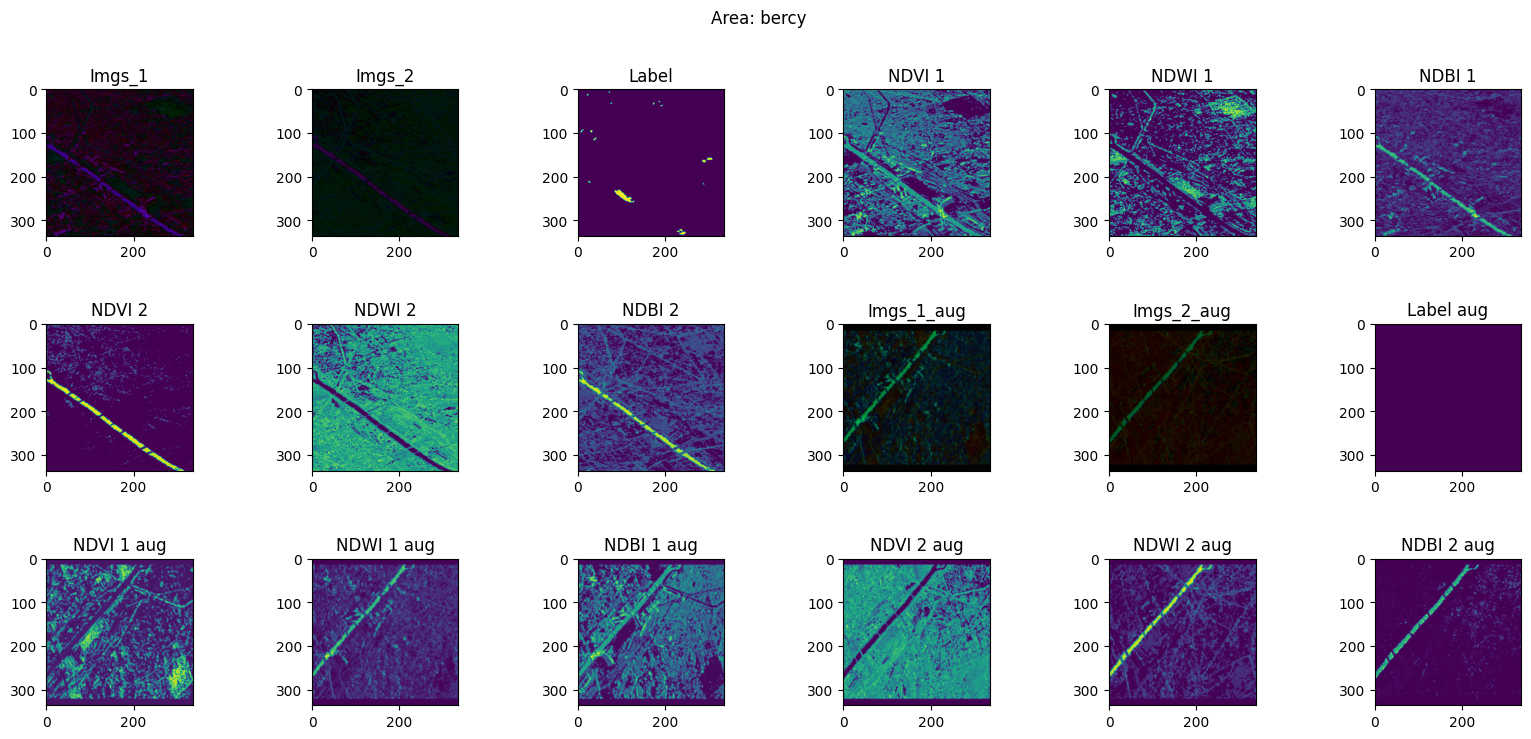

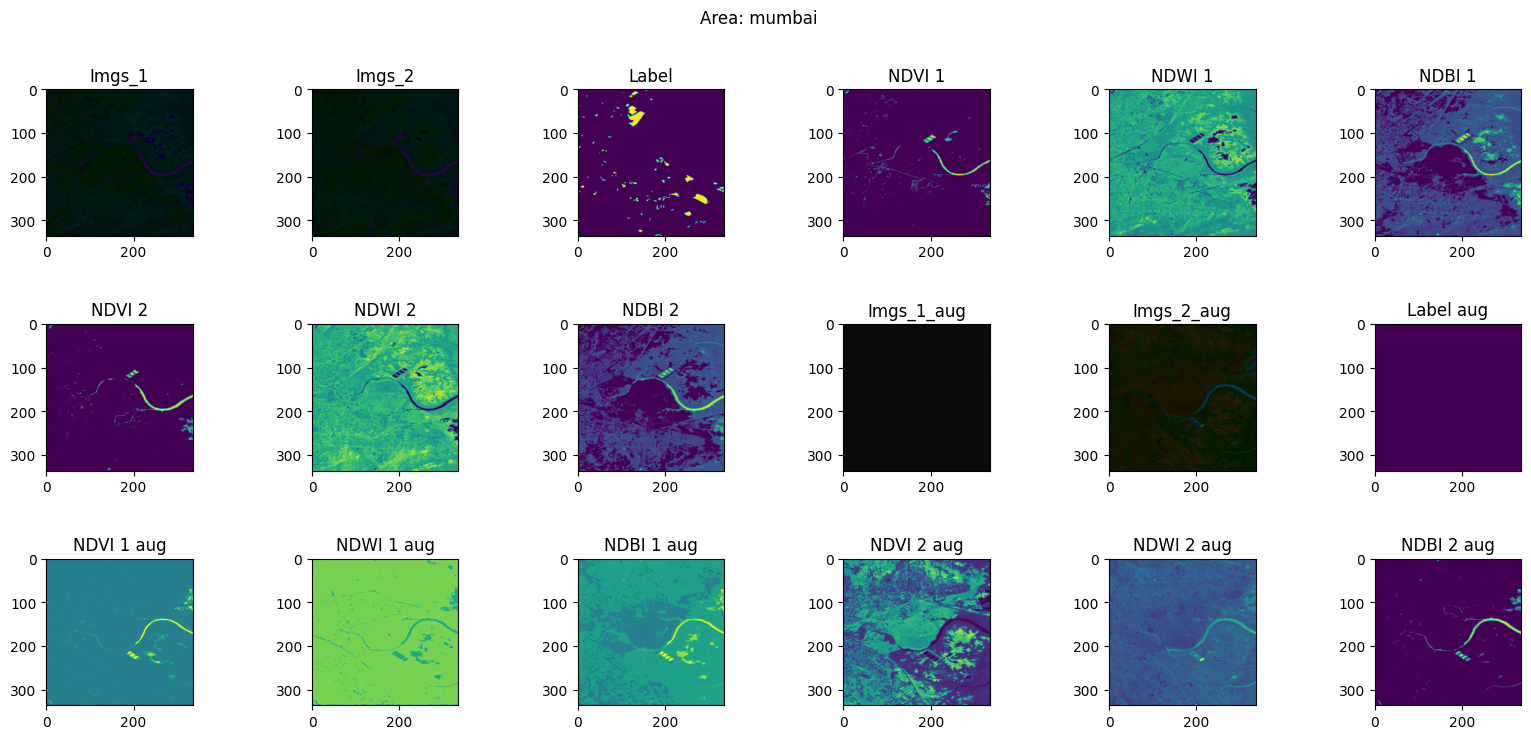

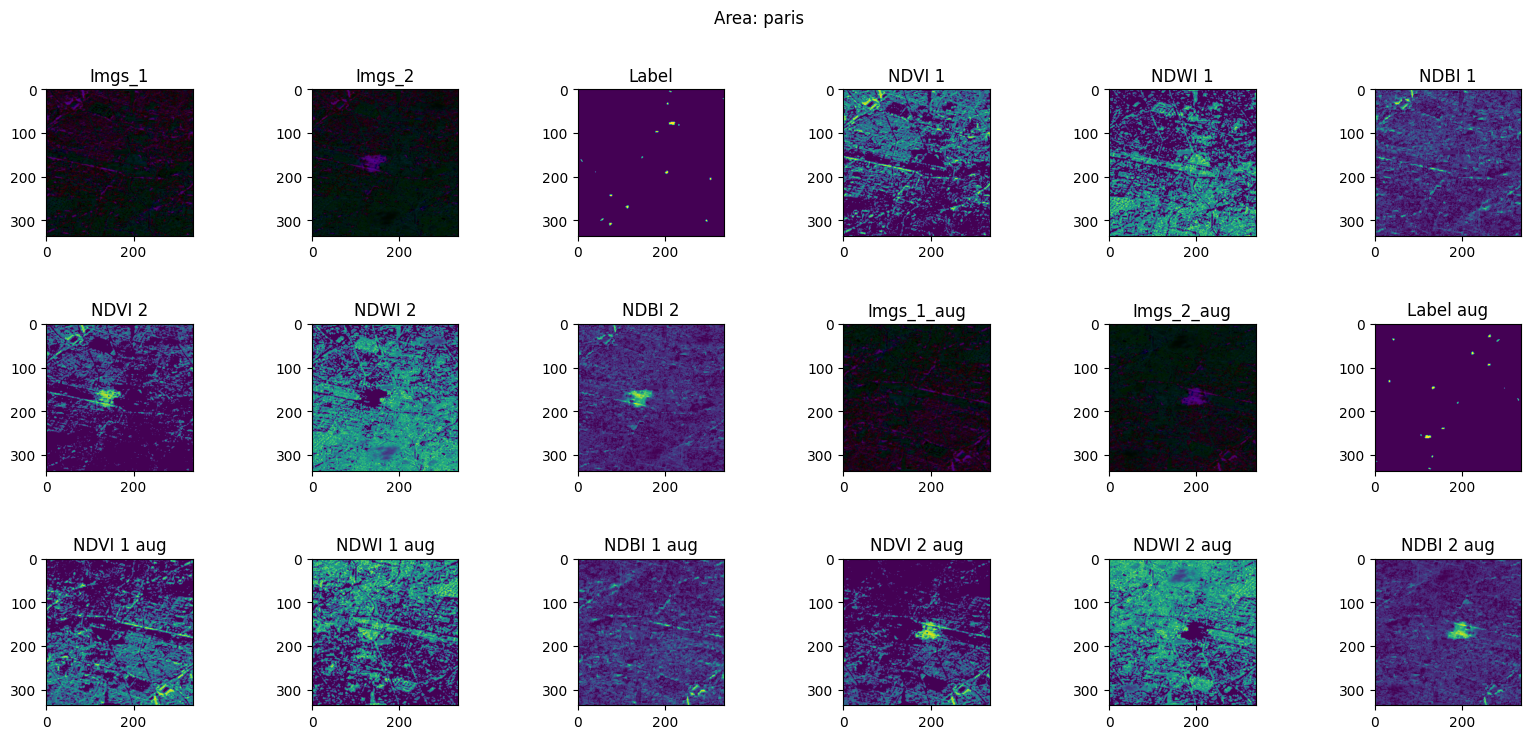

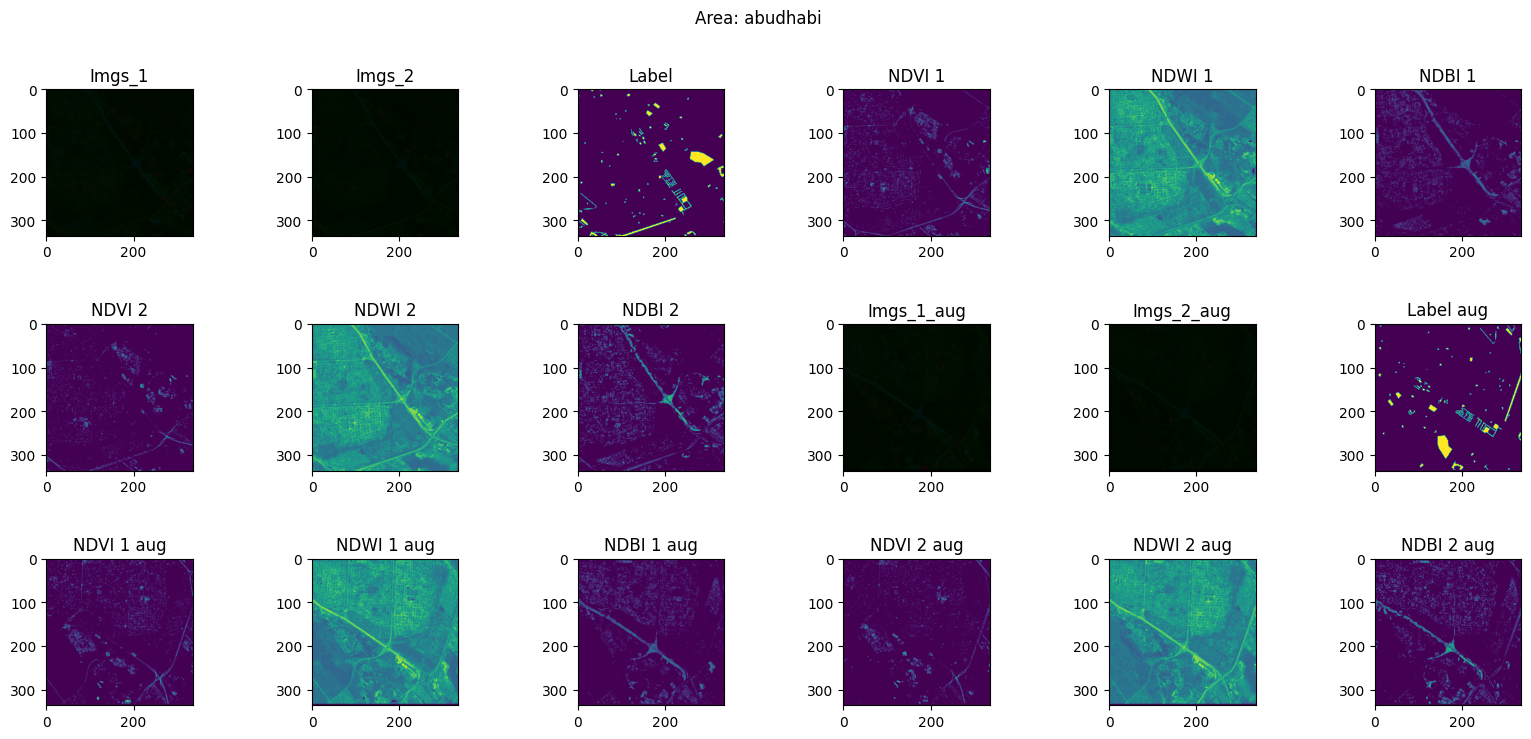

In [11]:
root_dir = "/content/gdrive/MyDrive/OSCD/Onera Satellite Change Detection dataset - "

num_samples_to_show = 4
transform_to_PIL = transforms.ToPILImage()

for i in range(num_samples_to_show):
    imgs_1, imgs_2, label = train_dataset[i]
    imgs_1_aug, imgs_2_aug, label_aug = train_dataset_augmentation[i]

    plt.figure(figsize=(20, 8))

    imgs_1_PIL = transform_to_PIL(imgs_1)
    imgs_2_PIL = transform_to_PIL(imgs_2)
    imgs_1_aug_PIL = transform_to_PIL(imgs_1_aug)
    imgs_2_aug_PIL = transform_to_PIL(imgs_2_aug)

    area_name = train_area_names[i]
    plt.suptitle(f"Area: {area_name}")

    # imgs_1
    plt.subplot(3, 6, 1)
    plt.title("Imgs_1")
    plt.imshow(imgs_1.permute(1,2,0))
    plt.savefig("imgs1.png")

    # imgs_2
    plt.subplot(3, 6, 2)
    plt.title("Imgs_2")
    plt.imshow(imgs_2.permute(1,2,0))
    plt.savefig("imgs2.png")

    # label
    plt.subplot(3, 6, 3)
    plt.title("Label")
    plt.imshow(label.permute(1,2,0))
    plt.savefig("label.png")

    # NDVI 1
    plt.subplot(3, 6, 4)
    plt.title("NDVI 1")
    plt.imshow(imgs_1[0])

    # NDWI 1
    plt.subplot(3, 6, 5)
    plt.title("NDWI 1")
    plt.imshow(imgs_1[1])

    # NDBI 1
    plt.subplot(3, 6, 6)
    plt.title("NDBI 1")
    plt.imshow(imgs_1[2])

    # NDVI 2
    plt.subplot(3, 6, 7)
    plt.title("NDVI 2")
    plt.imshow(imgs_2[0])

    # NDWI 2
    plt.subplot(3, 6, 8)
    plt.title("NDWI 2")
    plt.imshow(imgs_2[1])

    # NDBI 2
    plt.subplot(3, 6, 9)
    plt.title("NDBI 2")
    plt.imshow(imgs_2[2])

    # imgs_1_aug
    plt.subplot(3, 6, 10)
    plt.title("Imgs_1_aug")
    plt.imshow(imgs_1_aug.permute(1,2,0))
    plt.savefig("imgs1_aug.png")

    # imgs_2_aug
    plt.subplot(3, 6, 11)
    plt.title("Imgs_2_aug")
    plt.imshow(imgs_2_aug.permute(1,2,0))
    plt.savefig("imgs2_aug.png")

    # label_aug
    plt.subplot(3, 6, 12)
    plt.title("Label aug")
    plt.imshow(label_aug.permute(1,2,0))
    plt.savefig("label_aug.png")

    # NDVI 1 aug
    plt.subplot(3, 6, 13)
    plt.title("NDVI 1 aug")
    plt.imshow(imgs_1_aug[0])

    # NDWI 1 aug
    plt.subplot(3, 6, 14)
    plt.title("NDWI 1 aug")
    plt.imshow(imgs_1_aug[1])

    # NDBI 1 aug
    plt.subplot(3, 6, 15)
    plt.title("NDBI 1 aug")
    plt.imshow(imgs_1_aug[2])

    # NDVI 2 aug
    plt.subplot(3, 6, 16)
    plt.title("NDVI 2 aug")
    plt.imshow(imgs_2_aug[0])

    # NDWI 2 aug
    plt.subplot(3, 6, 17)
    plt.title("NDWI 2 aug")
    plt.imshow(imgs_2_aug[1])

    # NDBI 2aug
    plt.subplot(3, 6, 18)
    plt.title("NDBI 2 aug")
    plt.imshow(imgs_2_aug[2])

    # Adjust space between rows
    plt.subplots_adjust(hspace=0.6)

    plt.show()


In [12]:
class Unet(nn.Module):
    """EF segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x.float()))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)


        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sigmoid(x11d)


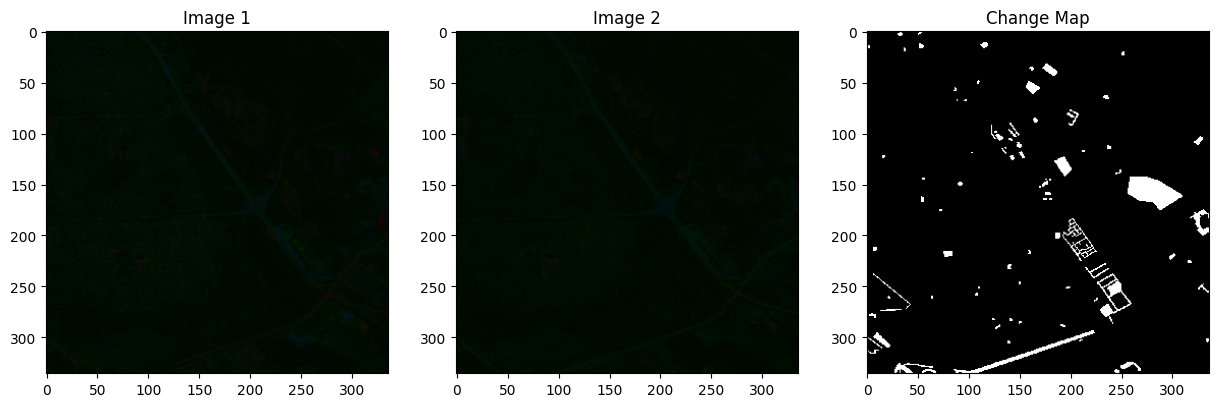

In [13]:
# Example from the train set
sample = next(iter(train_loader))
img1, img2, change_mask = sample

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1[0].permute(1, 2, 0).numpy())
plt.title('Image 1')
plt.subplot(1, 3, 2)
plt.imshow(img2[0].permute(1, 2, 0).numpy())
plt.title('Image 2')
plt.subplot(1, 3, 3)
plt.imshow(change_mask[0].squeeze().numpy(), cmap='gray')
plt.title('Change Map')

# Save the plot as Image
plt.savefig('change_map.png')

# Show the Plot
plt.show()

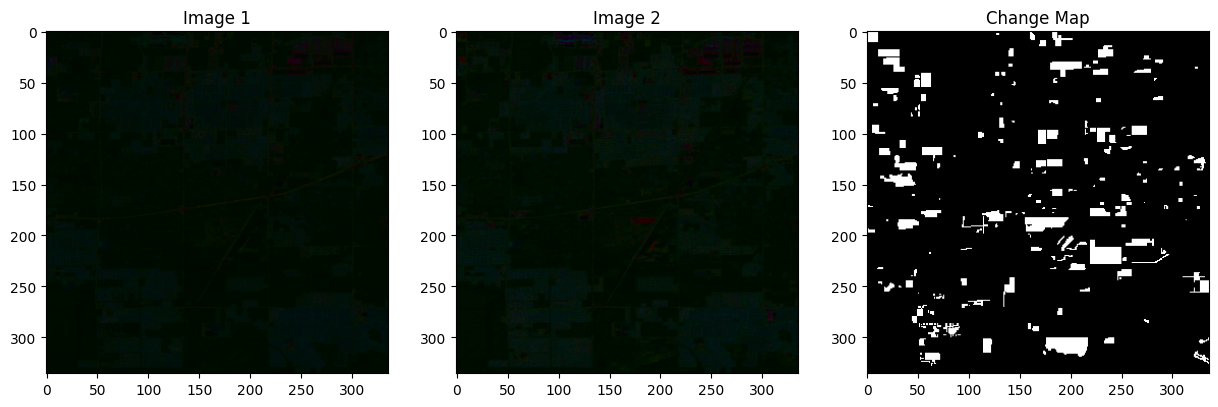

In [14]:
# Example from the test set
sample = next(iter(test_loader))
img1, img2, change_mask = sample

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1[0].permute(1, 2, 0).numpy())
plt.title('Image 1')
plt.subplot(1, 3, 2)
plt.imshow(img2[0].permute(1, 2, 0).numpy())
plt.title('Image 2')
plt.subplot(1, 3, 3)
plt.imshow(change_mask[0].squeeze().numpy(), cmap='gray')
plt.title('Change Map')

# Save the plot as Image
plt.savefig('change_map_test.png')

# Show the Plot
plt.show()

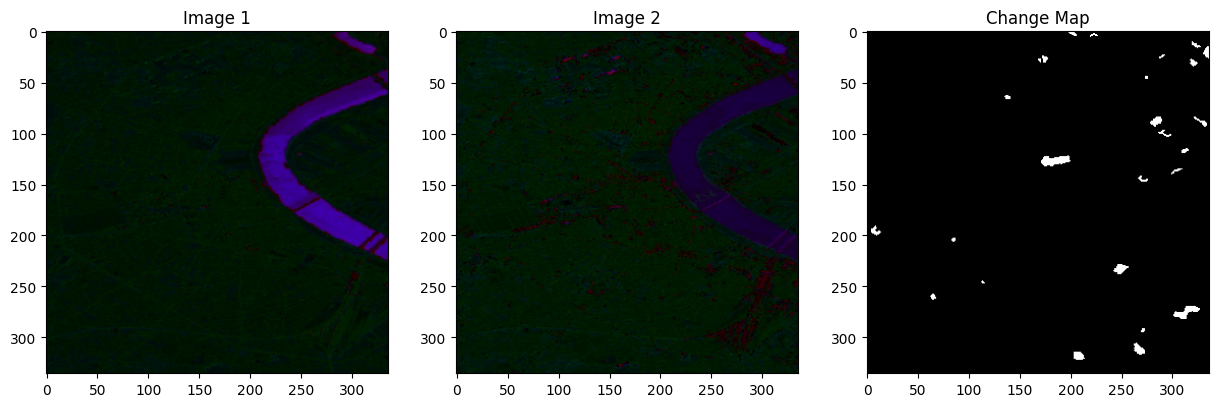

In [15]:
# Example from the validation set
sample = next(iter(val_loader))
img1, img2, change_mask = sample

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img1[0].permute(1, 2, 0).numpy())
plt.title('Image 1')
plt.subplot(1, 3, 2)
plt.imshow(img2[0].permute(1, 2, 0).numpy())
plt.title('Image 2')
plt.subplot(1, 3, 3)
plt.imshow(change_mask[0].squeeze().numpy(), cmap='gray')
plt.title('Change Map')

# Save the plot as Image
plt.savefig('change_map_validation.png')

# Show the Plot
plt.show()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Total positive and negative examples in training set
total_positive_examples = 0
total_negative_examples = 0

for imgs_1, imgs_2, label in train_loader:
    label_np = np.array(label.squeeze().cpu())  # move to CPU and convert to array numpy
    positive_pixels = np.sum(label_np == 1)
    total_positive_examples += positive_pixels
    total_negative_examples += (label_np.size - positive_pixels)

# Total positive and negative examples in training set with Data Augmentation
total_positive_examples_aug = 0
total_negative_examples_aug = 0

for imgs_1, imgs_2, label in train_loader_augmentation:
    label_np = np.array(label.squeeze().cpu())  # move tensor to CPU before convert to numpy
    positive_pixels = np.sum(label_np == 1)
    total_positive_examples_aug += positive_pixels
    total_negative_examples_aug += (label_np.size - positive_pixels)

# Ratio between positive and negative classes without data augmentation
class_balance_ratio = total_negative_examples / total_positive_examples

# pos_weight parameter without augmentation
pos_weight = torch.tensor(class_balance_ratio, dtype=torch.float32).to(device)

# Ratio between positive and negative classes with data augmentation
class_balance_ratio_aug = total_negative_examples_aug / total_positive_examples_aug

# pos_weight parameter with augmentation
pos_weight_augmentation = torch.tensor(class_balance_ratio_aug, dtype=torch.float32).to(device)

pos_weight, pos_weight_augmentation

(tensor(57.5864), tensor(83.1879))

In [17]:
for imgs_1, imgs_2, label in train_loader:
    print(torch.min(label), torch.max(label))
    break
for imgs_1, imgs_2, label in train_loader_augmentation:
    print(torch.min(label), torch.max(label))
    break

tensor(0) tensor(1)
tensor(0) tensor(1)


In [18]:
model = Unet(input_nbr=6, label_nbr=1)
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for imgs_1, imgs_2, labels in train_loader:
        imgs_1, imgs_2, labels = imgs_1.to(device), imgs_2.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs_1, imgs_2)

        labels = labels.float()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy().flatten())

    avg_train_loss = total_loss / len(train_loader)
    return avg_train_loss

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for imgs_1, imgs_2, labels in val_loader:
            imgs_1, imgs_2, labels = imgs_1.to(device), imgs_2.to(device), labels.to(device)

            outputs = model(imgs_1, imgs_2)

            labels = labels.float()

            val_loss += criterion(outputs, labels).item()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy().flatten())

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

# Training loop NO augmentation
loss_history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': []
}
num_epochs = 25

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)

    loss_history['epoch'].append(epoch + 1)
    loss_history['train_loss'].append(train_loss)
    loss_history['val_loss'].append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

    torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

    df_loss = pd.DataFrame(loss_history)
    df_loss.to_csv('training_loss.csv', index=False)

Epoch [1/25] - Training Loss: 1.4296 - Validation Loss: 1.5539
Epoch [2/25] - Training Loss: 1.4136 - Validation Loss: 1.5448
Epoch [3/25] - Training Loss: 1.3884 - Validation Loss: 1.5372
Epoch [4/25] - Training Loss: 1.3857 - Validation Loss: 1.5344
Epoch [5/25] - Training Loss: 1.3951 - Validation Loss: 1.5312
Epoch [6/25] - Training Loss: 1.3834 - Validation Loss: 1.5300
Epoch [7/25] - Training Loss: 1.3726 - Validation Loss: 1.5273
Epoch [8/25] - Training Loss: 1.3559 - Validation Loss: 1.5245
Epoch [9/25] - Training Loss: 1.3686 - Validation Loss: 1.5235
Epoch [10/25] - Training Loss: 1.3338 - Validation Loss: 1.5235
Epoch [11/25] - Training Loss: 1.3504 - Validation Loss: 1.5226
Epoch [12/25] - Training Loss: 1.3291 - Validation Loss: 1.5225
Epoch [13/25] - Training Loss: 1.3514 - Validation Loss: 1.5206
Epoch [14/25] - Training Loss: 1.3310 - Validation Loss: 1.5193
Epoch [15/25] - Training Loss: 1.3285 - Validation Loss: 1.5180
Epoch [16/25] - Training Loss: 1.3265 - Validatio

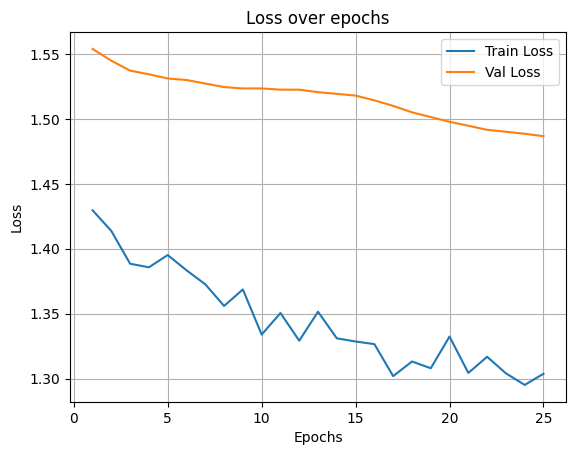

In [19]:
df_loss = pd.read_csv('training_loss.csv')

# Plot the metrics
def plot_metric(loss_name, df_loss):
    plt.plot(df_loss['epoch'], df_loss[f'train_{loss_name}'], label=f'Train {loss_name.capitalize()}')
    plt.plot(df_loss['epoch'], df_loss[f'val_{loss_name}'], label=f'Val {loss_name.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(loss_name.capitalize())
    plt.title(f'{loss_name.capitalize()} over epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{loss_name}.png')
    plt.show()

# show the plots
plot_metric('loss', df_loss)

In [20]:
criterion_augmentation = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_augmentation.to(device))

# Training loop with augmentation
loss_aug_history = {
    'epoch': [],
    'train_loss_aug': [],
    'val_loss_aug': []
}

for epoch in range(num_epochs):
    train_loss_aug = train_epoch(model, train_loader_augmentation, criterion_augmentation, optimizer)
    val_loss_aug = validate(model, val_loader_augmentation, criterion_augmentation)

    loss_aug_history['epoch'].append(epoch + 1)
    loss_aug_history['train_loss_aug'].append(train_loss_aug)
    loss_aug_history['val_loss_aug'].append(val_loss_aug)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {train_loss_aug:.4f} - Validation Loss: {val_loss_aug:.4f}")

    torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

    df_loss_aug = pd.DataFrame(loss_aug_history)
    df_loss_aug.to_csv('training_loss_augmentation.csv', index=False)

Epoch [1/25] - Training Loss: 1.3833 - Validation Loss: 1.6519
Epoch [2/25] - Training Loss: 1.2051 - Validation Loss: 1.5174
Epoch [3/25] - Training Loss: 1.2706 - Validation Loss: 1.3843
Epoch [4/25] - Training Loss: 1.1286 - Validation Loss: 1.3487
Epoch [5/25] - Training Loss: 1.2298 - Validation Loss: 1.4929
Epoch [6/25] - Training Loss: 1.2281 - Validation Loss: 1.4775
Epoch [7/25] - Training Loss: 0.9417 - Validation Loss: 1.4228
Epoch [8/25] - Training Loss: 1.3442 - Validation Loss: 1.4683
Epoch [9/25] - Training Loss: 1.3599 - Validation Loss: 1.5930
Epoch [10/25] - Training Loss: 1.2771 - Validation Loss: 1.6798
Epoch [11/25] - Training Loss: 1.4984 - Validation Loss: 1.0338
Epoch [12/25] - Training Loss: 1.2201 - Validation Loss: 1.1018
Epoch [13/25] - Training Loss: 1.1971 - Validation Loss: 1.3106
Epoch [14/25] - Training Loss: 1.1345 - Validation Loss: 1.4321
Epoch [15/25] - Training Loss: 1.4025 - Validation Loss: 1.4659
Epoch [16/25] - Training Loss: 1.2158 - Validatio

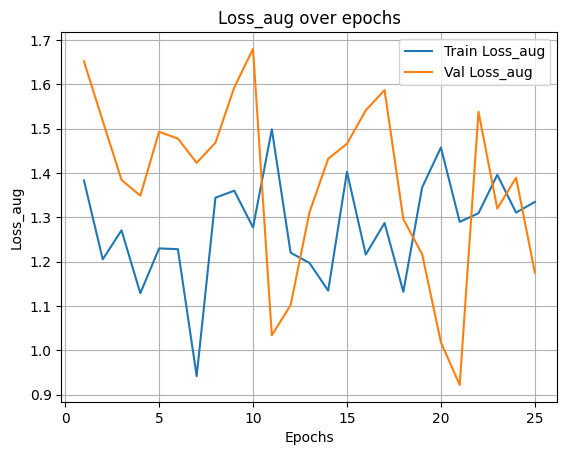

In [21]:
df_loss_aug = pd.read_csv('training_loss_augmentation.csv')

# Show the plots
plot_metric('loss_aug', df_loss_aug)

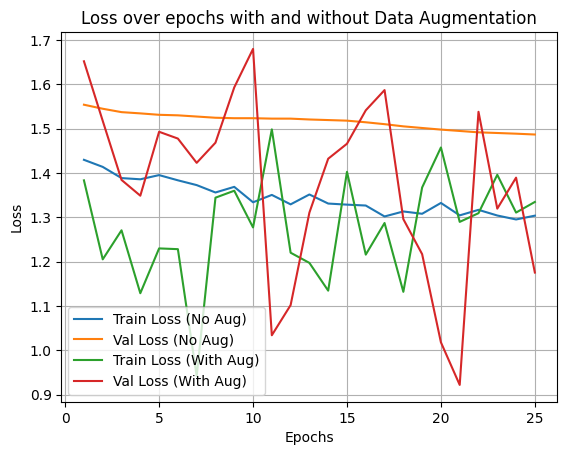

In [22]:
# Funzione modificata per includere entrambi i DataFrame
def plot_metric_comparison(loss_name, df_loss, df_loss_aug):
    # Plot per il dataset senza augmentation
    plt.plot(df_loss['epoch'], df_loss[f'train_{loss_name}'], label=f'Train {loss_name.capitalize()} (No Aug)')
    plt.plot(df_loss['epoch'], df_loss[f'val_{loss_name}'], label=f'Val {loss_name.capitalize()} (No Aug)')

    # Plot per il dataset con augmentation
    plt.plot(df_loss_aug['epoch'], df_loss_aug[f'train_{loss_name}_aug'], label=f'Train {loss_name.capitalize()} (With Aug)')
    plt.plot(df_loss_aug['epoch'], df_loss_aug[f'val_{loss_name}_aug'], label=f'Val {loss_name.capitalize()} (With Aug)')

    # Configura il grafico
    plt.xlabel('Epochs')
    plt.ylabel(loss_name.capitalize())
    plt.title(f'{loss_name.capitalize()} over epochs with and without Data Augmentation')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{loss_name}_comparison.png')
    plt.show()

# Visualizza il grafico
plot_metric_comparison('loss', df_loss, df_loss_aug)

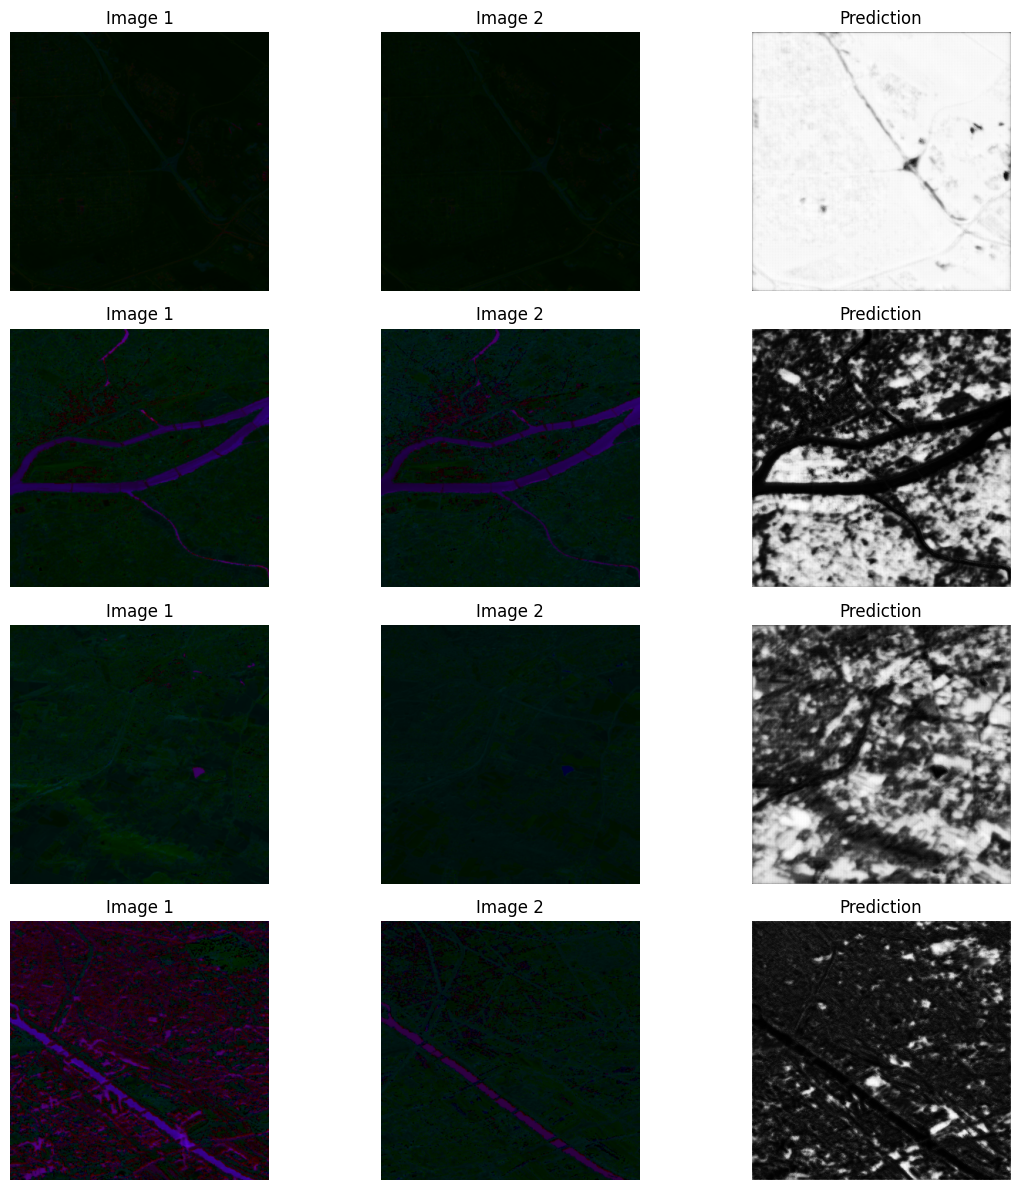

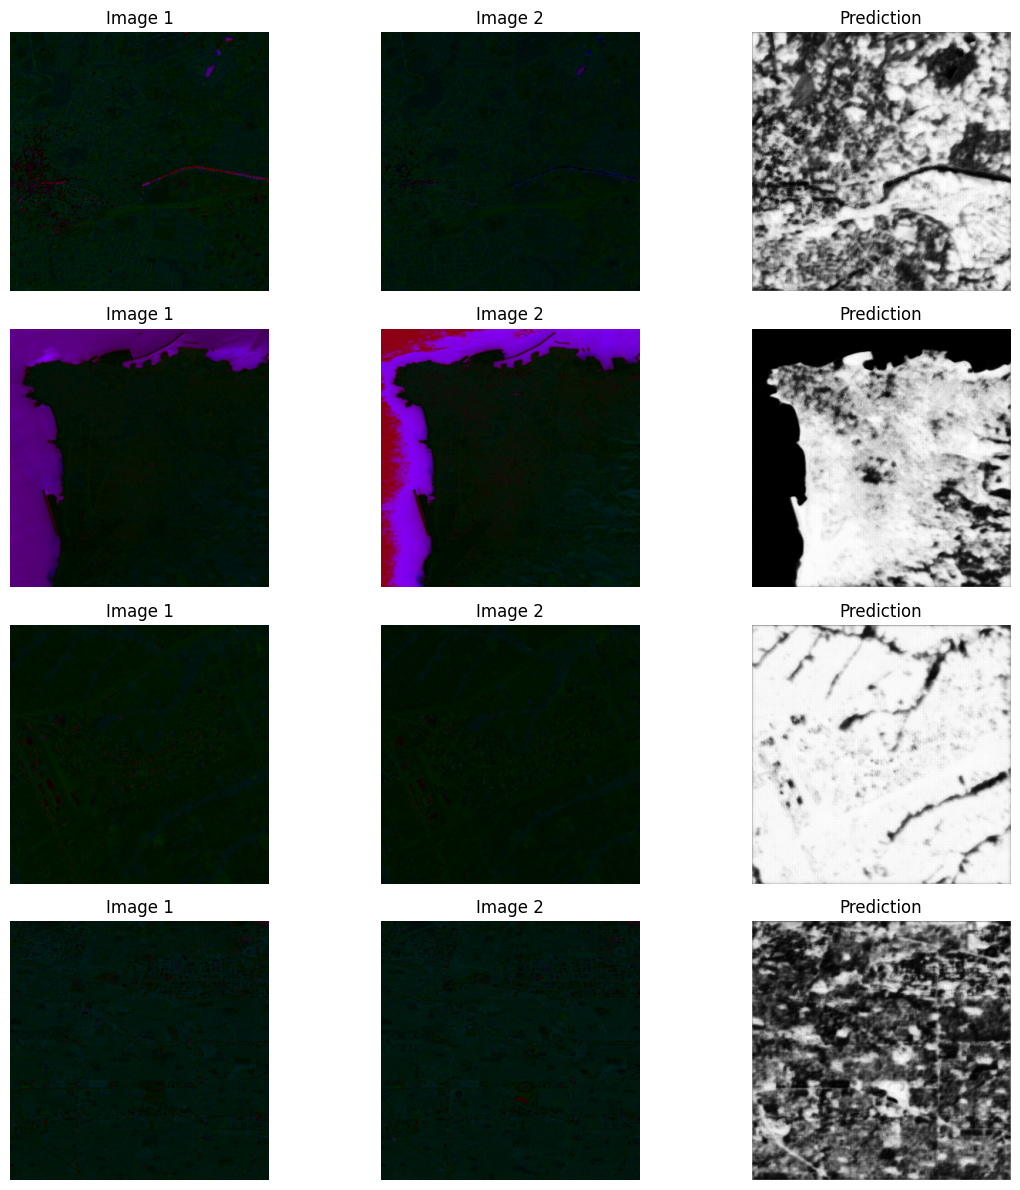

In [23]:
def show_predictions(model, loader, device):
    model.eval()
    imgs_1, imgs_2, labels = next(iter(loader))
    imgs_1, imgs_2, labels = imgs_1.to(device), imgs_2.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(imgs_1, imgs_2)
        preds = torch.sigmoid(outputs)

    imgs_1 = imgs_1.cpu().numpy()
    imgs_2 = imgs_2.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    num_images = 4
    fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images * 3))

    for i in range(num_images):
        axes[i, 0].imshow(imgs_1[i].transpose(1, 2, 0))  # Convert in HxWxC
        axes[i, 0].set_title("Image 1")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(imgs_2[i].transpose(1, 2, 0))
        axes[i, 1].set_title("Image 2")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(preds[i, 0], cmap="gray")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.savefig(f'{loader}_predictions.png')
    plt.show()

show_predictions(model, train_loader, device)
show_predictions(model, val_loader, device)

In [24]:
# Function to get predictions and labels
def get_predictions_and_labels(dataloader):
    predictions = []
    ground_truth = []

    model.eval()
    with torch.no_grad():
        for imgs_1, imgs_2, labels in dataloader:
            outputs = model(imgs_1, imgs_2)  # Model output per batch

            _, predicted = torch.max(outputs, 1)  # Multiclasse
            #predicted = (outputs > 0.5).long()  # Per classificazione binaria

            # Flatten predictions and labels for pixel-level comparison
            predictions.extend(predicted.cpu().int().flatten())
            ground_truth.extend(labels.cpu().int().flatten())

    # Convert lists to numpy arrays for metric calculation
    return np.array(predictions), np.array(ground_truth)

# Calculate metrics
def calculate_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    # Se è binario, puoi usare average='binary'
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)  # Cambia a 'binary' se è binario
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    return precision, recall, f1, accuracy

# Predictions and ground truth for various sets
train_predictions, train_ground_truth = get_predictions_and_labels(train_loader)
train_predictions_aug, train_ground_truth_aug = get_predictions_and_labels(train_loader_augmentation)
val_predictions, val_ground_truth = get_predictions_and_labels(val_loader)
val_predictions_aug, val_ground_truth_aug = get_predictions_and_labels(val_loader_augmentation)
test_predictions, test_ground_truth = get_predictions_and_labels(test_loader)
test_predictions_aug, test_ground_truth_aug = get_predictions_and_labels(test_loader_augmentation)

# Metrics without augmentation
precision_test, recall_test, f1_score_test, accuracy_test = calculate_metrics(test_predictions, test_ground_truth)
precision_train, recall_train, f1_score_train, accuracy_train = calculate_metrics(train_predictions, train_ground_truth)
precision_val, recall_val, f1_score_val, accuracy_val = calculate_metrics(val_predictions, val_ground_truth)

# Metrics with augmentation
precision_test_aug, recall_test_aug, f1_score_test_aug, accuracy_test_aug = calculate_metrics(test_predictions_aug, test_ground_truth_aug)
precision_train_aug, recall_train_aug, f1_score_train_aug, accuracy_train_aug = calculate_metrics(train_predictions_aug, train_ground_truth_aug)
precision_val_aug, recall_val_aug, f1_score_val_aug, accuracy_val_aug = calculate_metrics(val_predictions_aug, val_ground_truth_aug)

# Print metrics
print("METRICS WITH NO AUGMENTATION:")
print(f"Accuracy Test: {accuracy_test:.4f} - Accuracy Train: {accuracy_train:.4f} - Accuracy Validation: {accuracy_val:.4f}")
print(f"Precision Test: {precision_test:.4f} - Precision Train: {precision_train:.4f} - Precision Validation: {precision_val:.4f}")
print(f"Recall Test: {recall_test:.4f} - Recall Train: {recall_train:.4f} - Recall Validation: {recall_val:.4f}")
print(f"F1-Score Test: {f1_score_test:.4f} - F1-Score Train: {f1_score_train:.4f} - F1-Score Validation: {f1_score_val:.4f}")

print("METRICS WITH AUGMENTATION:")
print(f"Accuracy Test: {accuracy_test_aug:.4f} - Accuracy Train: {accuracy_train_aug:.4f} - Accuracy Validation: {accuracy_val_aug:.4f}")
print(f"Precision Test: {precision_test_aug:.4f} - Precision Train: {precision_train_aug:.4f} - Precision Validation: {precision_val_aug:.4f}")
print(f"Recall Test: {recall_test_aug:.4f} - Recall Train: {recall_train_aug:.4f} - Recall Validation: {recall_val_aug:.4f}")
print(f"F1-Score Test: {f1_score_test_aug:.4f} - F1-Score Train: {f1_score_train_aug:.4f} - F1-Score Validation: {f1_score_val_aug:.4f}")


METRICS WITH NO AUGMENTATION:
Accuracy Test: 0.9564 - Accuracy Train: 0.9829 - Accuracy Validation: 0.9778
Precision Test: 0.9147 - Precision Train: 0.9662 - Precision Validation: 0.9562
Recall Test: 0.9564 - Recall Train: 0.9829 - Recall Validation: 0.9778
F1-Score Test: 0.9351 - F1-Score Train: 0.9745 - F1-Score Validation: 0.9669
METRICS WITH AUGMENTATION:
Accuracy Test: 0.9608 - Accuracy Train: 0.9928 - Accuracy Validation: 0.9841
Precision Test: 0.9232 - Precision Train: 0.9856 - Precision Validation: 0.9684
Recall Test: 0.9608 - Recall Train: 0.9928 - Recall Validation: 0.9841
F1-Score Test: 0.9416 - F1-Score Train: 0.9892 - F1-Score Validation: 0.9761


In [25]:
# Dictionary of metrics
metrics = {
    'Accuracy' : {'train' : [accuracy_train], 'test' : [accuracy_test], 'validation' : [accuracy_val]},
    'Precision' : {'train' : [precision_train], 'test' : [precision_test], 'validation' : [precision_val]},
    'Recall' : {'train' : [recall_train], 'test' : [recall_test], 'validation' : [recall_val]},
    'F1Score' : {'train' : [f1_score_train], 'test' : [f1_score_test], 'validation' : [f1_score_val]}
}

metrics_aug = {
    'Accuracy' : {'train' : [accuracy_train_aug], 'test' : [accuracy_test_aug], 'validation' : [accuracy_val_aug]},
    'Precision' : {'train' : [precision_train_aug], 'test' : [precision_test_aug], 'validation' : [precision_val_aug]},
    'Recall' : {'train' : [recall_train_aug], 'test' : [recall_test_aug], 'validation' : [recall_val_aug]},
    'F1Score' : {'train' : [f1_score_train_aug], 'test' : [f1_score_test_aug], 'validation' : [f1_score_val_aug]}
}

# dictionary as dataframe
df_metrics = pd.DataFrame(metrics).T  # transpose df
df_metrics_aug = pd.DataFrame(metrics_aug).T  # transose df

df_metrics = df_metrics.map(lambda x: x[0] if isinstance(x, list) else x)
df_metrics_aug = df_metrics_aug.map(lambda x: x[0] if isinstance(x, list) else x)

df_metrics.to_csv('metrics.csv', index=True)
df_metrics_aug.to_csv('metrics_aug.csv', index=True)

print(df_metrics)
print(df_metrics_aug)


              train      test  validation
Accuracy   0.982931  0.956422    0.977842
Precision  0.966154  0.914743    0.956175
Recall     0.982931  0.956422    0.977842
F1Score    0.974470  0.935118    0.966887
              train      test  validation
Accuracy   0.992786  0.960812    0.984052
Precision  0.985624  0.923159    0.968359
Recall     0.992786  0.960812    0.984052
F1Score    0.989192  0.941609    0.976143


In [26]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, labels):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, labels)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return torch.mean(focal_loss)

num_epochs = 25

criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_focal_losses=[]
val_focal_losses=[]

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Focal loss on training set
    for imgs_1, imgs_2, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(imgs_1, imgs_2)

        #labels = labels/255
        labels = labels.float()#.unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_focal_losses.append(avg_train_loss)

    model.eval()

    total_val_loss = 0

    # Focal loss on validation set
    with torch.no_grad():
        for imgs_1, imgs_2, labels in val_loader:
            optimizer.zero_grad()
            outputs = model(imgs_1, imgs_2)

            #labels = labels/255
            labels = labels.float()#.unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_focal_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")


Epoch [1/25] - Training Loss: 0.2690 - Validation Loss: 0.4253
Epoch [2/25] - Training Loss: 0.2765 - Validation Loss: 0.4325
Epoch [3/25] - Training Loss: 0.2378 - Validation Loss: 0.4301
Epoch [4/25] - Training Loss: 0.2624 - Validation Loss: 0.4153
Epoch [5/25] - Training Loss: 0.2193 - Validation Loss: 0.4064
Epoch [6/25] - Training Loss: 0.2433 - Validation Loss: 0.3849
Epoch [7/25] - Training Loss: 0.2359 - Validation Loss: 0.3490
Epoch [8/25] - Training Loss: 0.2160 - Validation Loss: 0.3240
Epoch [9/25] - Training Loss: 0.2112 - Validation Loss: 0.2908
Epoch [10/25] - Training Loss: 0.2242 - Validation Loss: 0.2762
Epoch [11/25] - Training Loss: 0.2027 - Validation Loss: 0.2662
Epoch [12/25] - Training Loss: 0.2118 - Validation Loss: 0.2532
Epoch [13/25] - Training Loss: 0.2143 - Validation Loss: 0.2424
Epoch [14/25] - Training Loss: 0.1983 - Validation Loss: 0.2262
Epoch [15/25] - Training Loss: 0.1956 - Validation Loss: 0.2141
Epoch [16/25] - Training Loss: 0.1886 - Validatio

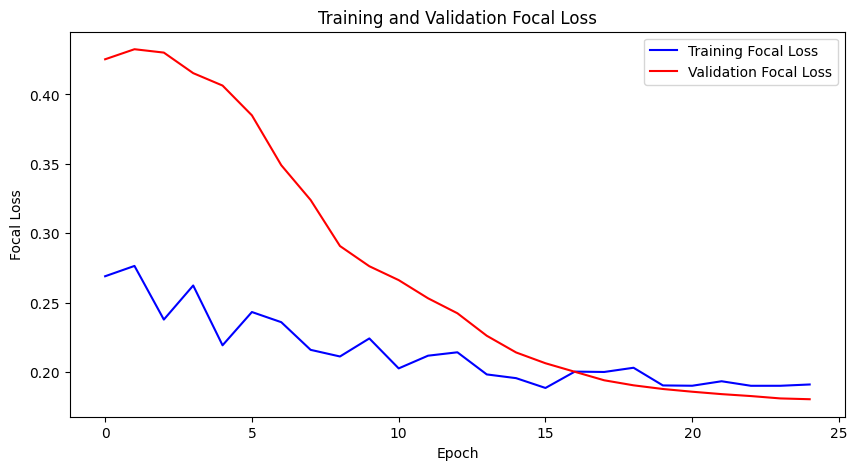

In [27]:
# Plot of the Focal Loss
plt.figure(figsize=(10, 5))
plt.plot(train_focal_losses, label='Training Focal Loss', color='blue')
plt.plot(val_focal_losses, label='Validation Focal Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Focal Loss')
plt.legend()
plt.title('Training and Validation Focal Loss')

# Save the plot as Image
plt.savefig('focal_loss_curves.png')

# Show the plot
plt.show()

In [28]:
train_focal_losses=[]
val_focal_losses=[]

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Focal loss on training set
    for imgs_1, imgs_2, labels in train_loader_augmentation:
        optimizer.zero_grad()
        outputs = model(imgs_1, imgs_2)

        labels = labels/255
        labels = labels.float()#.unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader_augmentation)
    train_focal_losses.append(avg_train_loss)

    model.eval()

    total_val_loss = 0

    # Focal loss on validation set
    with torch.no_grad():
        for imgs_1, imgs_2, labels in val_loader_augmentation:
            optimizer.zero_grad()
            outputs = model(imgs_1, imgs_2)

            labels = labels/255
            labels = labels.float()#.unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader_augmentation)
    val_focal_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss with Data Augmentation: {avg_train_loss:.4f} - Validation Loss with Data Augmentation: {avg_val_loss:.4f}")

Epoch [1/25] - Training Loss with Data Augmentation: 0.1841 - Validation Loss with Data Augmentation: 0.1800
Epoch [2/25] - Training Loss with Data Augmentation: 0.1864 - Validation Loss with Data Augmentation: 0.1817
Epoch [3/25] - Training Loss with Data Augmentation: 0.1923 - Validation Loss with Data Augmentation: 0.1825
Epoch [4/25] - Training Loss with Data Augmentation: 0.1823 - Validation Loss with Data Augmentation: 0.1811
Epoch [5/25] - Training Loss with Data Augmentation: 0.1806 - Validation Loss with Data Augmentation: 0.1800
Epoch [6/25] - Training Loss with Data Augmentation: 0.1859 - Validation Loss with Data Augmentation: 0.1797
Epoch [7/25] - Training Loss with Data Augmentation: 0.1807 - Validation Loss with Data Augmentation: 0.1817
Epoch [8/25] - Training Loss with Data Augmentation: 0.1836 - Validation Loss with Data Augmentation: 0.1798
Epoch [9/25] - Training Loss with Data Augmentation: 0.1817 - Validation Loss with Data Augmentation: 0.1801
Epoch [10/25] - Tra

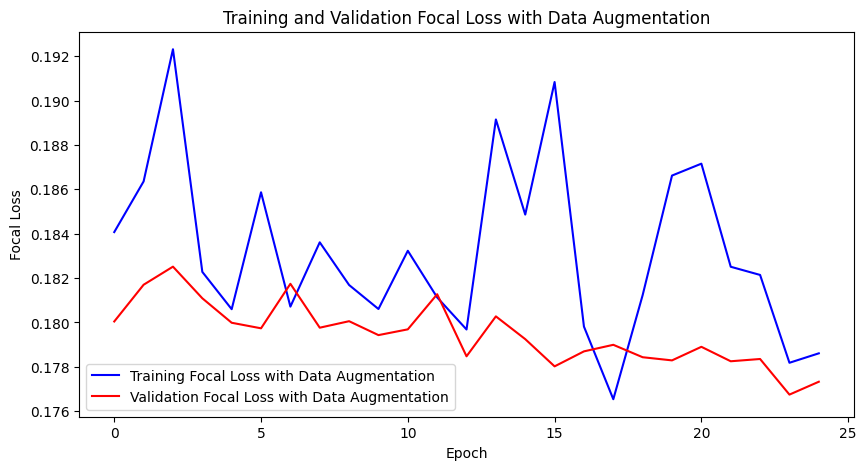

In [29]:
# Plot of the Focal Loss
plt.figure(figsize=(10, 5))
plt.plot(train_focal_losses, label='Training Focal Loss with Data Augmentation', color='blue')
plt.plot(val_focal_losses, label='Validation Focal Loss with Data Augmentation', color='red')
plt.xlabel('Epoch')
plt.ylabel('Focal Loss')
plt.legend()
plt.title('Training and Validation Focal Loss with Data Augmentation')

# Save the plot as Image
plt.savefig('focal_loss_curves_augmentation.png')

# Show the plot
plt.show()

Copyright:
Sentinel Images:
This dataset contains modified Copernicus data from 2015-2018. Original Copernicus Sentinel Data available from the European Space Agency (https://sentinel.esa.int).

Change labels:
Change maps are released under Creative-Commons BY-NC-SA. For commercial purposes, please contact the authors.